<a href="https://colab.research.google.com/github/Melvinmcrn/PatternRecognition/blob/master/HW4/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using Tensorflow and Keras. Tensorflow is a deep learning framwork developed by Google, and Keras is a frontend library built on top of Tensorflow (or Theano, CNTK) to provide an easier way to use standard layers and networks.

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with Keras ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for keras in this notebook but feel free to modify those parts to suit your needs. You can also complete this exercise using only Tensorflow (without using Keras). Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours). 

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfal in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

## Loading the data
Get the data set by going [here](https://drive.google.com/file/d/1NWR22fVVE0tO2Q5EbaPPrRKPhUem-jbw/view?usp=sharing) and click add to drive.

In [8]:
# tensorboard extension
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [9]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.models import load_model

tf.__version__

'2.0.0-dev20191002'

In [10]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [11]:
#!unzip '/content/gdrive/My Drive/dataset.zip'
!tar -xvf '/content/gdrive/My Drive/Colab notebook/nowcastingHWdataset.tar.gz'
#!tar -xvf '/content/gdrive/My Drive/pattern/pattern2018/homework/HW4/nowcastingHWdataset.tar.gz'
!ls

tar: /content/gdrive/My Drive/Colab notebook/nowcastingHWdataset.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
dataset  gdrive  sample_data


# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [0]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)
        
        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [13]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features** 
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries 

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

In [0]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

# Three-Layer Feedforward Neural Networks

Below, the code for creating a 3-layers fully connected neural network in keras is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [15]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_scaler = normalizer_std(x_train_ff)
    x_train_ff = x_scaler.transform(x_train_ff)
    x_val_ff = x_scaler.transform(x_val_ff)
    return x_train_ff, y_train_ff, x_val_ff, y_val_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)


Explain each line of code in the function preprocess_for_ff()

**Ans:** <br>
บรรทัดที่ 1-4 เป็นการ reshape เพื่อให้สามารถใช้ feedforward model ได้<br>
บรรทัดที่ 5 เป็นการ normalize ตัว train data<br>
บรรทัดที่ 6-7 เป็นการ transform ตัว train data<br>



In [0]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def get_feedforward_nn():    
    input1 = Input(shape=(75,))    
    x = Dense(200, activation='relu')(input1)    
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.01),
                loss='mse',
                metrics=['mse'])

    return model

What is the activation function in the final dense layer? and why?

**Ans:**<br>
reLu เพราะว่าปริมาณน้ำฝนจะมีค่า >= 0 เสมอ

Why is the loss MSE?

**Ans:**<br>
เพราะเราต้องการรู้ว่าค่าที่ทำนายออกมาต่างจากความเป็นจริงมากน้อยแค่ไหน

In [17]:
from tensorflow.keras import backend as K
# This is called to clear the original model session in order to use TensorBoard
K.clear_session()

model_ff = get_feedforward_nn()
# .summary provies an overview of the model
model_ff.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               15200     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
_________________________________________________________________


Explain why dense_1 has 15200 parameters

**Ans:** <br>
เพราะมาจาก input จาก Layer ก่อนหน้ามีขนาด 75 และจาก Layer ปัจจุบันมีขนาด 200 ออกมาได้ 15,000 และ + bias เข้าไปอีก 200 จะได้ 15,200

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau

print('start training ff')

# Path to save model parameters
weight_path_model_ff ='model_ff_nn.h5'
# Path to write tensorboard
tensorboard_path_model_ff = 'Graphs/ff_nn'

callbacks_list_model_ff_nn = [
    TensorBoard(log_dir=tensorboard_path_model_ff, histogram_freq=1, write_graph=True, write_grads=True),
    ModelCheckpoint(
            weight_path_model_ff,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
]

verbose = 1
epochs, batch_size = [10,1024]

history_ff = model_ff.fit(x_train_ff, y_train_ff, epochs=epochs, batch_size=batch_size, verbose=verbose,
                callbacks=callbacks_list_model_ff_nn, validation_data=(x_val_ff, y_val_ff))

start training ff
Train on 1147740 samples, validate on 464195 samples
Epoch 1/10
1146880/1147740 [============================>.] - ETA: 0s - loss: 1.9915 - mse: 1.9915
Epoch 00001: val_loss improved from inf to 1.66080, saving model to model_ff_nn.h5
1147740/1147740 [==============================] - 26s 23us/sample - loss: 1.9910 - mse: 1.9910 - val_loss: 1.6608 - val_mse: 1.6608
Epoch 2/10
1144832/1147740 [============================>.] - ETA: 0s - loss: 1.9225 - mse: 1.9225
Epoch 00002: val_loss improved from 1.66080 to 1.65934, saving model to model_ff_nn.h5
1147740/1147740 [==============================] - 25s 22us/sample - loss: 1.9214 - mse: 1.9214 - val_loss: 1.6593 - val_mse: 1.6593
Epoch 3/10
1146880/1147740 [============================>.] - ETA: 0s - loss: 1.9212 - mse: 1.9212
Epoch 00003: val_loss did not improve from 1.65934
1147740/1147740 [==============================] - 23s 20us/sample - loss: 1.9202 - mse: 1.9202 - val_loss: 1.6608 - val_mse: 1.6608
Epoch 4/10
1

history_ff tracks many useful information. Checkout what is included by running the code below.

In [19]:
print(history_ff.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


We can track many of the parameters using the history. Plot loss, mean_squared_error, val_mean_squared_error, and val_loss as a function of epochs.

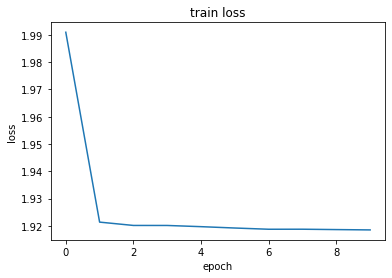

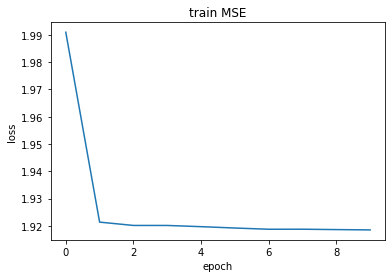

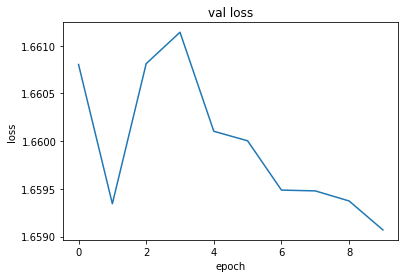

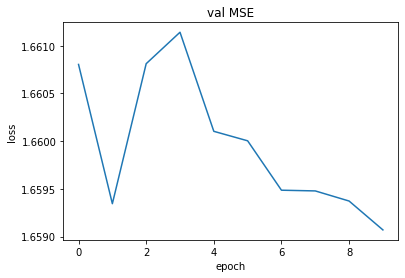

In [27]:
## TODO#1 ##
train_loss = history_ff.history['loss']
train_mse = history_ff.history['mse']
val_loss = history_ff.history['val_loss']
val_mse = history_ff.history['val_mse']

plt.plot(train_loss)
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(train_mse)
plt.title('train MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(val_loss)
plt.title('val loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

plt.plot(val_mse)
plt.title('val MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

<details>
    <summary>PARTIAL SOLUTION HERE!</summary>
      <pre>
        <code>
train_loss = history_ff.history['loss']
train_mse = history_ff.history['mean_squared_error']
val_loss = history_ff.history['val_loss']
val_mse = history_ff.history['val_mean_squared_error']

plt.plot(train_loss)
plt.title('train loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
        </code>
      </pre>
</details>

When does the model start to overfit?

**Ans:**<br>
เมื่อ train loss เริ่มมีค่าลดลงเรื่อยๆ แต่ val loss มีค่าเพิ่มขึ้น

Plot the learning rate as a function of the epochs.

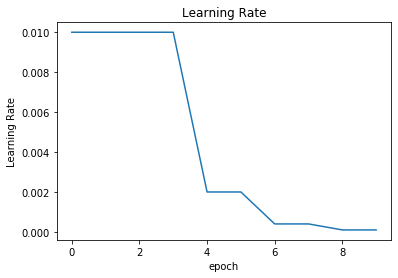

In [29]:
## TODO#2 ##
lr = history_ff.history['lr']

plt.plot(lr)
plt.title('Learning Rate')
plt.ylabel('Learning Rate')
plt.xlabel('epoch')
plt.show()

What makes the learning rate change?
(hint: look at the callback [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau))


**Ans:**<br>
ค่า factor ซึ่งคือ 0.2 ซึ่ง new learning rate = 0.2 * learning rate <br>
ค่า patience คือจำนวนอย่างน้อยของ epoch ที่ loss มากขึ้น แล้วจึงจะคูณ factor เข้าไปเพื่อปรับ lr

In [0]:
################################################################################
# TODO#3:                                                                      #
# Write a function to evaluate your model. Your function must make prediction  #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: https://keras.io/models/model#evaluate                                 #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(features, labels, model):
    """
    Evaluate model on validation data
    """
    # write code here (one line)
    mse = model.evaluate(x=features, y=labels)
    
    return mse

In [0]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [22]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [31]:
print('FF-model')
print('train', evaluate(x_train_ff, y_train_ff, model_ff))
print('validate', evaluate(x_val_ff, y_val_ff, model_ff))

FF-model


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train [1.9184200537940466, 1.9184284]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



validate [1.6590703465384389, 1.6590669]


# (Optional) Tensorboard #
The code provided also have Tensorboard (a visualization tool that comes with Tensorflow). Note the part that calls it `TensorBoard(log_dir='./Graph/' + graph_name, histogram_freq=1, write_graph=True, write_grads=True)`. This tells Tensorflow to write extra outputs to the `log_dir` which can then be used for visualization.

To use Tensorboard follow the guide [here](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)

In Tensorboard, you will be able to debug your computation graph which can be hard to keep track in code. This is might seem trivial in Keras, but it is very helpful for Tensorflow. You can see a visualization of the computation graph at the `GRAPH` tab. If you see multiple dense layers (more than 4), this is caused by running the code several times without deleting the log dir. Delete the log dir and re-run the code.

Next, let's look at the scalars tab, we can see the loss and accuracy on the training and validation set as they change over each epoch. This can be useful to detect overfitting.

Another useful tab is the histograms tab. This plot histograms of the weights, biases, and outputs of each layer. The depth of the histograms show the change over epochs. We can see how the histograms of weights change over the training peroid. This can be used to debug vanishing gradients or getting stuck in local minimas.

There are other useful tabs in Tensorboard, you can read about them in the Keras [documentation](https://keras.io/callbacks/#tensorboard) for tensorboard.

In [32]:
# Graphs/ff_nn is a path of tensorboard_path_model_ff
# %tensorboard --logdir Graphs/ff_nn

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 59, in run_main
    default.get_plugins() + default.get_dynamic_plugins(),
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/default.py", line 110, in get_dynamic_plugins
    for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins')
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/default.py", line 110, in <listcomp>
    for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins')
  File "/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py", line 2442, in load
    self.require(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pkg_resources/__init__.py", line 2465, in require
    items = working_set.resolve(reqs, env, installer, extras=self.extras)
  Fil

# Tensorboard observation #

**Optional TODO#1** Write your own interpretation of the logs from this example. A simple sentence or two for each tab is sufficient.

**Your answer:** 

# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

In [0]:
# Run this code just in case to clear the session of tensorflow
K.clear_session()

In [0]:
################################################################################
# TODO#4:                                                                      #
# Write a function that return feedforward model with dropout                  #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
from tensorflow.keras.layers import Dropout
def get_fully_connected_with_dropout():
    #enter code below
        
    input1 = Input(shape=(75,))    
    x = Dense(200, activation='relu')(input1)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(200, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.01),
                loss='mse',
                metrics=['mse'])


    return model

In [38]:
model_ff_dropout = get_fully_connected_with_dropout()
model_ff_dropout.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
dense (Dense)                (None, 200)               15200     
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201   

In [41]:
################################################################################
# TODO#5:                                                                      #
# Complete the code to train your dropout model                                #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
print('start training ff dropout')

# Path to save model parameters
weight_path_model_ff_dropout ='model_ff_nn.h5'
# Path to write tensorboard
tensorboard_path_model_ff_dropout = 'Graphs/ff_nn'

callbacks_list_model_ff_dropout_nn = [
    TensorBoard(log_dir=tensorboard_path_model_ff_dropout, histogram_freq=1, write_graph=True, write_grads=True),
    ModelCheckpoint(
            weight_path_model_ff,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
]

verbose = 1
epochs, batch_size = [10,1024]

history_ff_dropout = model_ff_dropout.fit(x_train_ff, y_train_ff, epochs=epochs, batch_size=batch_size, verbose=verbose,
                callbacks=callbacks_list_model_ff_dropout_nn, validation_data=(x_val_ff, y_val_ff))

start training ff dropout
Train on 1147740 samples, validate on 464195 samples
Epoch 1/10
1146880/1147740 [============================>.] - ETA: 0s - loss: 1.9844 - mse: 1.9844
Epoch 00001: val_loss improved from inf to 1.66484, saving model to model_ff_nn.h5
1147740/1147740 [==============================] - 31s 27us/sample - loss: 1.9839 - mse: 1.9839 - val_loss: 1.6648 - val_mse: 1.6648
Epoch 2/10
1146880/1147740 [============================>.] - ETA: 0s - loss: 1.9226 - mse: 1.9226
Epoch 00002: val_loss improved from 1.66484 to 1.66036, saving model to model_ff_nn.h5
1147740/1147740 [==============================] - 30s 26us/sample - loss: 1.9229 - mse: 1.9229 - val_loss: 1.6604 - val_mse: 1.6604
Epoch 3/10
1145856/1147740 [============================>.] - ETA: 0s - loss: 1.9166 - mse: 1.9166
Epoch 00003: val_loss did not improve from 1.66036
1147740/1147740 [==============================] - 30s 26us/sample - loss: 1.9206 - mse: 1.9206 - val_loss: 1.6610 - val_mse: 1.6610
Epoc

Plot the losses and MSE of the training and validation as before

In [44]:
history_ff_dropout.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])

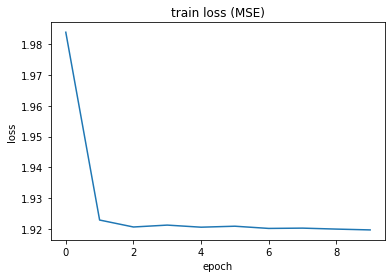

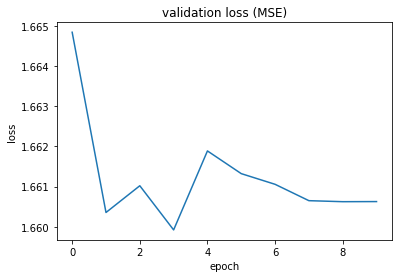

In [45]:
train_loss_drop = history_ff_dropout.history['loss']
train_mse_drop = history_ff_dropout.history['mse']
val_loss_drop = history_ff_dropout.history['val_loss']
val_mse_drop = history_ff_dropout.history['val_mse']

plt.plot(train_loss_drop)
plt.title('train loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.plot(val_loss_drop)
plt.title('validation loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
################################################################################
# TODO#6:                                                                      #
# Complete the code to evaluate your dropout model                             #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate_dropout(features, labels, model):
    """
    Evaluate model on validation data
    """
    ## enter code below
    mse = model.evaluate(x=features, y=labels)
    
    return mse

In [47]:
print('FF-dropout-model')
print('train', evaluate(x_train_ff, y_train_ff, model_ff_dropout))
print('validate', evaluate(x_val_ff, y_val_ff, model_ff_dropout))

FF-dropout-model


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



train [1.9194770736646836, 1.9194757]


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



validate [1.6606276666551885, 1.6606284]


# Convolution Neural Networks
Now, you are going to implement you own 2d-convolution neural networks with the following structure.
```
_________________________________________________________________
Layer (type)                 Output Shape              Param
=================================================================
input_1 (InputLayer)         (None, 5, 5, 3)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 200)         5600      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               360200    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
=================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
_________________________________________________________________
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read keras documentation to see the list of available layers and options you can use.                         

In [0]:
K.clear_session()

In [0]:
################################################################################
# TODO#7:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten
def preprocess_for_cnn(x_train, y_train, x_val, y_val):
    # Enter code below
    
    x_train_cnn = x_train.reshape((-1, 5*5*3))
    y_train_cnn = y_train.reshape((-1, 1))
    x_val_cnn = x_val.reshape((-1, 5*5*3))
    y_val_cnn = y_val.reshape((-1, 1))
    x_scaler = normalizer_std(x_train_cnn)
    x_train_cnn = x_scaler.transform(x_train_cnn)
    x_val_cnn = x_scaler.transform(x_val_cnn)
    

    return x_train_cnn,y_train_cnn,x_val_cnn,y_val_cnn

In [0]:
################################################################################
# TODO#8:                                                                     #
# Write a function that returns keras convolution nueral network model.        #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def get_conv2d_nn():
    # Enter code below
    input1 = Input(shape=(75,))    
    x = Dense(200, activation='relu')(input1)    
    x = Dense(200, activation='relu')(x)
    x = Dense(200, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.01),
                loss='mse',
                metrics=['mse'])
    
    return model

In [0]:
################################################################################
# TODO#9:                                                                     #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
# Hint: Read about callbacks_list argument on the documentation. You might     #
# find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     #
# process. Feel free to use any other callback function available.             #
################################################################################

print('start training conv2d')
model_cnn = get_conv2d_nn()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [0]:
history_cnn.history.keys()
train_loss_cnn = history_cnn.history['loss']
train_mse_cnn = history_cnn.history['mean_squared_error']
val_loss_cnn = history_cnn.history['val_loss']
val_mse_cnn = history_cnn.history['val_mean_squared_error']

plt.plot(train_loss_cnn)
plt.title('train loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.plot(val_loss_cnn)
plt.title('validation loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
print('CNN-model')
print('train', evaluate(x_train_cnn, y_train_cnn, model_cnn))
print('validate', evaluate(x_val_cnn, y_val_cnn, model_cnn))

# Gated Recurrent Units

Now, you are going to implement you own GRU network with the following structure.
```
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         (None, 5, 75)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 5, 200)            165600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 200)            40200     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 1)              201       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
=================================================================
Total params: 206,001
Trainable params: 206,001
Non-trainable params: 0
_________________________________________________________________
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult keras documentation on how to use [GRUs](https://keras.io/layers/recurrent/).


In [0]:
K.clear_session()

In [0]:
################################################################################
# TODO#10:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.          #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
from tensorflow.keras.layers import GRU,TimeDistributed

def preprocess_for_gru(x_train, y_train, x_val, y_val):
    # Enter code below
    
    return x_train_gru, y_train_gru, x_val_gru, y_val_gru

In [0]:
################################################################################
# TODO#11                                                                      #
# Write a function that returns keras GRU network model.                       #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

def get_gru():
    # Enter code below
    
    return model

In [0]:
################################################################################
# TODO#12                                                                      #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
# Hint: Read about callbacks_list argument on the documentation. You might     #
# find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     #
# process. Feel free to use any other callback function available.             #
################################################################################
print('start training gru')
model_gru = get_gru()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [0]:
history_gru.history.keys()
train_loss_gru = history_gru.history['loss']
train_mse_gru = history_gru.history['mean_squared_error']
val_loss_gru = history_gru.history['val_loss']
val_mse_gru = history_gru.history['val_mean_squared_error']

plt.plot(train_loss_gru)
plt.title('train loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
plt.plot(val_loss_gru)
plt.title('validation loss (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [0]:
print('GRU-model')
print('train', evaluate(x_train_gru, y_train_gru, model_gru))
print('validate', evaluate(x_val_gru, y_val_gru, model_gru))

# Final Section
# Keras playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find TensorBoard helpful in tuning of complicated models.    
Your model should be better than your CNN or GRU model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining CNN with GRUs

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [0]:
K.clear_session()

In [0]:
################################################################################
# TODO#13                                                                       #
# Write a function that returns keras your best model. You can use anything    #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read keras documentation to see the list of available       #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

def get_my_best_model():
    pass
    return 

In [0]:
################################################################################
# TODO#14                                                                       #
# Write code that call model.fit, or model.fit_generator if you have data      #
# generator, to train you models. Make sure you have validation_data as an     # 
# argument and use verbose=2 to generate one log line per epoch. Select your   #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
# Hint: Read about callbacks_list argument on the documentation. You might     #
# find  ReduceLROnPlateau() and ModelCheckpoint() useful for your training     #
# process. Feel free to use any other callback function available.             #
################################################################################
print('start training the best model')
my_best_model = get_my_best_model()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
pass

In [0]:
#evaluate(x_val_best, y_val_best, model)
#evaluate(x_test_best, y_test_best, model)
#Also evaluate your fully-connected model and CNN/GRU model on the test set.

To get full credit for this part, your best model should be better than the previous models on the **test set**. 


Explain what helped and what did not help here

**Ans:**